In [1]:
from preamble import *

In [2]:
#------------------------------------------------------------#
MaxIntFilter = 64 #knots
#------------------------------------------------------------#

In [3]:
# Load the ibtracs dataset
dataset = pd.read_csv('Data/IBTrACS/data_ibtracs_JTWC.csv')

# Apply VMAX corrections
dataset['A_VMAX'] = 0.1884 * dataset['VMAX']**1.288
dataset['VMAX2'] = 0
dataset.loc[dataset['YEAR'] < 1968, 'VMAX2'] = 0.4 * dataset['VMAX'] + 0.6 * dataset['A_VMAX']
dataset.loc[dataset['YEAR'].between(1968,1972), 'VMAX2'] = 0.8 * dataset['VMAX'] + 0.2 * dataset['A_VMAX']
dataset.loc[dataset['YEAR'] > 1972, 'VMAX2'] = dataset['VMAX']
dataset = dataset.drop(['VMAX','A_VMAX'], axis=1)
dataset = dataset.rename(columns={'VMAX2': 'VMAX'})

In [4]:
# Determine maximum intensity of the each cyclone
max_int = dataset.groupby('CycNo')['VMAX'].max().rename('VMAX').reset_index()

# Remove cyclones with maximum intensity lower than defined
max_int = max_int[max_int['VMAX'] > MaxIntFilter]
dataset = dataset[dataset['CycNo'].isin(max_int['CycNo'])]

In [5]:
# Remove cylones that did not start in West Pacific
# dataset = dataset[dataset['GENESIS']==2]

### 1. Average Maximum Intensity

In [6]:
# Determine the years in which the cyclones occured
year_occur = dataset.groupby('CycNo')['YEAR'].agg(lambda x: stats.mode(x)[0][0]).astype(int).reset_index()

In [7]:
# Determine maximum intensity of each cyclone
max_int = dataset.groupby('CycNo')['VMAX'].max().reset_index()

In [8]:
# Create a table containing metrics for each cyclones
cyclone_metrics = year_occur.merge(max_int, on ='CycNo', how='inner')

### 2. Average Intensification Rate

In [9]:
dataset['TIMESTAMP'] = pd.to_datetime('1858-11-17', format='%Y-%m-%d') + pd.to_timedelta(dataset['S_TIME'], unit='d')

In [10]:
def int_rate(data):
    data = data[(data.index >= data[data['VMAX']>=64].index[0]-1) & (data.index <= (data['VMAX'].idxmax()+1))]
    data = data.set_index('TIMESTAMP')
    data = data.resample('6h').interpolate(method='time').reset_index()
    result = data['VMAX'].rolling(min_periods=3, window=3, center=True).apply(lambda x: (x[2] - x[0])/2)
    return result.mean()

# Calculate average intensification rate
ave_int_rate = dataset.groupby('CycNo').apply(int_rate).rename('Intensification Rate').reset_index()

In [11]:
# List cyclones with invalid intensification rate
invalid_cyclone = ave_int_rate[ave_int_rate.isnull().any(axis=1)]['CycNo'].values
invalid_cyclone

array([ 5852.,  6680.])

In [12]:
cyclone_metrics = cyclone_metrics.merge(ave_int_rate, on ='CycNo', how='inner')

### 3. Average Intensification Duration

In [13]:
def duration(data):
    time_start = data[data['VMAX']>=64].iloc[0]['S_TIME']
    time_peak = data['S_TIME'][data['VMAX'].idxmax()]
    dur = time_peak-time_start

    if dur == 0:
        data = data.set_index('TIMESTAMP')
        data = data.resample('10Min').interpolate(method='time').reset_index()
        time_start = data[data['VMAX']>=64].iloc[0]['S_TIME']
        time_peak = data['S_TIME'][data['VMAX'].idxmax()]
        dur = time_peak-time_start
    
    return dur
        
# Determine average intensification duration
int_duration = dataset.groupby('CycNo').apply(duration).rename('Intensification Duration').reset_index()

In [14]:
# List cyclones with invalid intensification duration
int_duration[int_duration['Intensification Duration'] == 0]['CycNo'].values

array([ 5852.,  6680.])

In [15]:
cyclone_metrics = cyclone_metrics.merge(int_duration, on ='CycNo', how='inner')

### 4. Data Analysis

In [16]:
# Removal of invalid cyclones
cyclone_metrics = cyclone_metrics[~cyclone_metrics['CycNo'].isin(invalid_cyclone)]

In [17]:
print('Number of cyclones for investigation: {}'.format(cyclone_metrics['CycNo'].nunique()))

Number of cyclones for investigation: 936


In [18]:
# Calculate annual mean of cyclone metrics
metrics = ['VMAX','Intensification Rate','Intensification Duration']
annual_cyclone_metrics = cyclone_metrics.groupby(['YEAR'])[metrics].mean().reset_index()

# Convert data to m/s
annual_cyclone_metrics['VMAX'] = annual_cyclone_metrics['VMAX']*0.514444
annual_cyclone_metrics['Intensification Rate'] = annual_cyclone_metrics['Intensification Rate']*0.514444

# Creat TIME column for plotting
annual_cyclone_metrics['TIME'] = pd.to_datetime(annual_cyclone_metrics['YEAR'], format='%Y')

In [19]:
# Calculate decadal mean for maximum intensity
rolling = annual_cyclone_metrics
rolling = rolling.set_index('TIME')

rolling = rolling.rolling(min_periods=9, window=9, center=True)[metrics].mean().reset_index()
rolling.columns = ['TIME', '9-year average VMAX', '9-year average Int Rate', '9-year average Int Duration']

# Merge with original cyclone metrics dataframe
annual_cyclone_metrics = annual_cyclone_metrics.merge(rolling, on ='TIME', how='inner')

### Average Maximum Intensity Plot

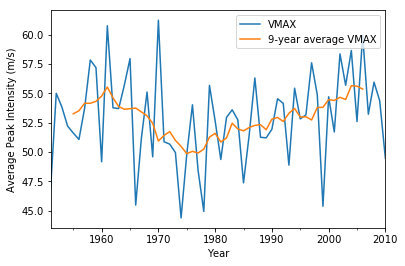

In [20]:
ax = annual_cyclone_metrics.plot('TIME', ['VMAX','9-year average VMAX'])
plt.ylabel('Average Peak Intensity (m/s)')
plt.xlabel('Year')
plt.show()

### Average Intensification Rate Plot

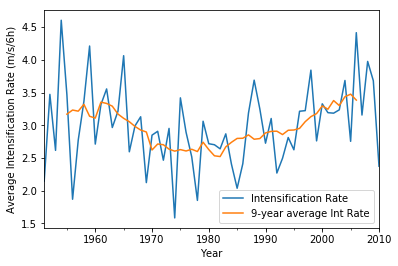

In [21]:
ax = annual_cyclone_metrics.plot('TIME', ['Intensification Rate','9-year average Int Rate'])
plt.ylabel('Average Intensification Rate (m/s/6h)')
plt.xlabel('Year')
plt.show()

### Average Intensification Duration Plot

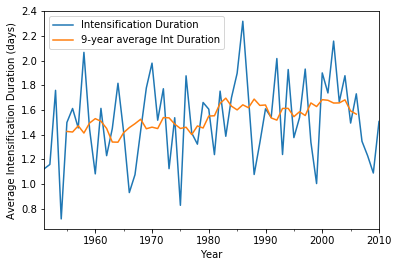

In [22]:
ax = annual_cyclone_metrics.plot('TIME', ['Intensification Duration','9-year average Int Duration'])
plt.ylabel('Average Intensification Duration (days)')
plt.xlabel('Year')
plt.show()

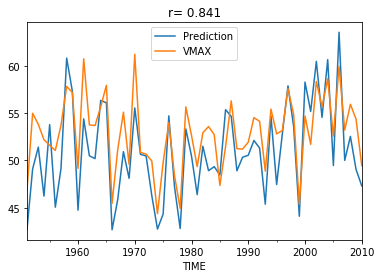

In [23]:
annual_cyclone_metrics['Prediction'] = annual_cyclone_metrics['Intensification Duration']*annual_cyclone_metrics['Intensification Rate']*4 + 33
ax = annual_cyclone_metrics.plot('TIME','Prediction')
annual_cyclone_metrics.plot('TIME','VMAX',ax=ax)
plt.title('r= {:.3f}'.format(np.corrcoef(annual_cyclone_metrics['Prediction'], annual_cyclone_metrics['VMAX'])[0][1]))
plt.show()

In [27]:
annual_cyclone_metrics[['YEAR','Intensification Rate', '9-year average Int Rate']].to_csv('Data/Computed-Data/computed_annual-intensification-rate_JTWC.csv',index=False)

In [28]:
annual_cyclone_metrics[['YEAR','Intensification Duration', '9-year average Int Duration']].to_csv('Data/Computed-Data/computed_annual-intensification-duration_JTWC.csv',index=False)

In [29]:
annual_cyclone_metrics[['YEAR','VMAX', '9-year average VMAX']].to_csv('Data/Computed-Data/computed_annual-max-intensity_JTWC.csv',index=False)